<a id='top'></a><a name='top'></a>
# Chapter 9: Adding a Custom Attention Layer to a RNN in Keras

* [Introduction](#introduction)
* [8.0 Imports and Setup](#8.0)
* [8.1 The Attention Mechanism](#8.1)
* [8.2 The General Attention Mechanism](#8.2)
* [8.3 The General Attention Mechanism with NumPy and SciPy](#8.3)
    - [8.3.1 Encoder representations of four different words](#8.3.1)
    - [8.3.2 Stacking the word embeddings into a single array](#8.3.2)
    - [8.3.3 Generate the weight matrices](#8.3.3)
    - [8.3.4 Generate the queries, keys and values with matrix multiplication](#8.3.4)
    - [8.3.5 Score the query vectors against all key vectors](#8.3.5)
    - [8.3.6 Compute the weights by a softmax operation](#8.3.6)
    - [8.3.7 Compute the attention by a weighted sum of the value vectors](#8.3.7)
* [Extra](#extra)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* Fibonacci sequence


### Explore

TODO

---
<a name='9.0'></a><a id='9.0'></a>
# 9.0 Imports and Setup
<a href="#top">[back to top]</a>

In [5]:
req_file = "requirements_09.txt"

In [6]:
%%writefile {req_file}
isort
scikit-learn-intelex
watermark

Overwriting requirements_09.txt


In [7]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

# Need to import before sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Running locally.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
%%writefile imports.py
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tqdm.auto import tqdm
from watermark import watermark

Overwriting imports.py


In [3]:
!isort imports.py --sl
!cat imports.py

import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tqdm.auto import tqdm
from watermark import watermark


In [ ]:
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tqdm.auto import tqdm
from watermark import watermark

In [6]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('default')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

seed = 42

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

pandas    : 1.5.3
tensorflow: 2.9.3
numpy     : 1.23.5
seaborn   : 0.12.1
matplotlib: 3.6.2



---
<a name='9.1'></a><a id='9.1'></a>
# 9.1 Preparing Dataset for Time Series Forecast
<a href="#top">[back to top]</a>

---
<a name='9.2'></a><a id='9.2'></a>
# 9.2 The SimpleRNN Network
<a href="#top">[back to top]</a>

#### Preparing the Dataset

Generate a sequence of Fibonacci numbers.

In [7]:
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
        
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler

fib_scaler, _ = get_fib_seq(10, False)
print(fib_scaler)

[ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


#### Reformat the sequence into input features and target values to be used by the Keras input layer.


In [8]:
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler


def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)
    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps-1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X, temp))
    # random permutation with fixed seed
    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX, (len(trainX), time_steps, 1))
    testX = np.reshape(testX, (len(testX), time_steps, 1))
    return trainX, trainY, testX, testY, scaler

#### Set up the Neural Network

Create a small NN with two layers. 

In [9]:
# Set up parameters
time_steps = 20

#hidden_units = 2
hidden_units = 10

epochs = 30

In [10]:
# Traditional RNN network
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    
    model.compile(
        loss='mse', 
        optimizer='adam',
    )
    
    return model

model_RNN = create_RNN(
    hidden_units=hidden_units,
    dense_units=1,
    input_shape=(time_steps, 1),
    activation=['tanh', 'tanh']
)

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


2023-06-16 12:07:49.336775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Train the Network and Evaluate

In [11]:
# Generate the dataset
trainX, trainY, testX, testY, scaler = get_fib_XY(
    1200, 
    time_steps, 
    0.7
)

# Train the network
hist = model_RNN.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=1,
    verbose=2
)

Epoch 1/30
826/826 - 3s - loss: 2.9562e-04 - 3s/epoch - 3ms/step
Epoch 2/30
826/826 - 2s - loss: 1.3697e-04 - 2s/epoch - 2ms/step
Epoch 3/30
826/826 - 2s - loss: 7.8733e-05 - 2s/epoch - 3ms/step
Epoch 4/30
826/826 - 2s - loss: 6.0331e-05 - 2s/epoch - 2ms/step
Epoch 5/30
826/826 - 2s - loss: 6.8072e-05 - 2s/epoch - 2ms/step
Epoch 6/30
826/826 - 2s - loss: 6.4058e-05 - 2s/epoch - 3ms/step
Epoch 7/30
826/826 - 2s - loss: 5.7261e-05 - 2s/epoch - 3ms/step
Epoch 8/30
826/826 - 2s - loss: 6.3679e-05 - 2s/epoch - 3ms/step
Epoch 9/30
826/826 - 2s - loss: 5.5886e-05 - 2s/epoch - 2ms/step
Epoch 10/30
826/826 - 2s - loss: 5.9221e-05 - 2s/epoch - 2ms/step
Epoch 11/30
826/826 - 2s - loss: 6.3544e-05 - 2s/epoch - 2ms/step
Epoch 12/30
826/826 - 2s - loss: 6.0875e-05 - 2s/epoch - 2ms/step
Epoch 13/30
826/826 - 2s - loss: 5.6626e-05 - 2s/epoch - 2ms/step
Epoch 14/30
826/826 - 2s - loss: 5.9321e-05 - 2s/epoch - 2ms/step
Epoch 15/30
826/826 - 2s - loss: 6.4157e-05 - 2s/epoch - 2ms/step
Epoch 16/30
826/826

In [12]:
hist.history.keys()

dict_keys(['loss'])

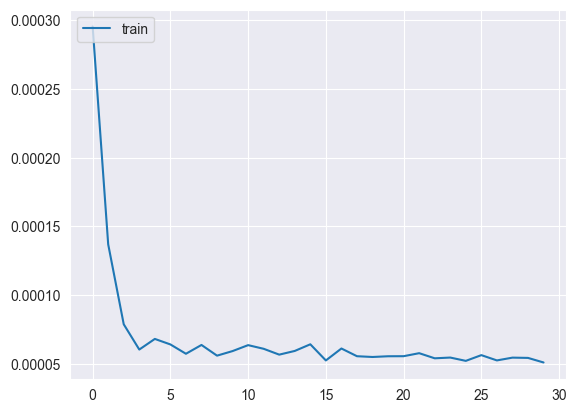

In [13]:
plt.plot(hist.history['loss'])
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
# Evaluate model
train_mse = model_RNN.evaluate(trainX, trainY, verbose=2)
test_mse = model_RNN.evaluate(testX, testY, verbose=2)
HR()

print(type(train_mse))
# Print error
print(f"Train MSE:\t{train_mse}")
print(f"Test MSE:\t{test_mse}")

26/26 - 0s - loss: 3.8612e-05 - 316ms/epoch - 12ms/step
12/12 - 0s - loss: 8.8961e-06 - 42ms/epoch - 4ms/step
----------------------------------------
<class 'float'>
Train MSE:	3.861229924950749e-05
Test MSE:	8.896144208847545e-06


---
---
---

### 9.3 Adding a Custom Attention Layer to the Deep Learning Network

* Write the __init__ method
* Override the build method
* Override the call method

```
K.tanh(K.dot(x, self.W)+self.b)
K.squeeze(e, axis=-1)
K.softmax(e)
K.expand_dims(alpha, axis=-1)
K.sum(context, axis=1)
```

In [15]:
class attention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)
        
    def call(self, x):
        # Alignment scores. Pass through the tanh function
        e = K.tanh(K.dot(x, self.W)+self.b)
        
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        
        # Compute weights
        alpha = K.softmax(e)
        
        # Reshape to Tensorflow format
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context        

#### RNN with Attention Layer

Add an attention layer to the earlier created RNN network.

The attention layer expects a sequence as input. To use it after the `SimpleRNN` layer, the latter should return a sequence. The function `create_RNN_with_attention` specifies an RNN layer, attention layer, and Dense layer. 

Make sure to set `return_sequences=True` with specifying the `SimpleRNN`. This will return the output of the hidden units for all previous time steps (eg as a sequence).

In [16]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    
    RNN_layer = SimpleRNN(
        hidden_units, 
        return_sequences=True, 
        activation=activation
    )(x)
    
    attention_layer = attention()(RNN_layer)
    
    outputs = Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    
    model=Model(x, outputs)
    
    model.compile(
        loss='mse', 
        optimizer='adam', 
        # metrics=['accuracy']
    )
    
    return model

In [17]:
# Create the model with attention, train and evaluate
model_attention = create_RNN_with_attention(
    hidden_units=hidden_units,
    dense_units=1,
    input_shape=(time_steps, 1),
    activation='tanh'
)

model_attention.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 10)            120       
                                                                 
 attention (attention)       (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


#### Train and Evaluate the Deep Learning Network with Attention

In [18]:
hist_ma = model_attention.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=1,
    verbose=2
)

Epoch 1/30
826/826 - 3s - loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 2/30
826/826 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 3/30
826/826 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 4/30
826/826 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 5/30
826/826 - 2s - loss: 0.0010 - 2s/epoch - 3ms/step
Epoch 6/30
826/826 - 2s - loss: 8.8789e-04 - 2s/epoch - 3ms/step
Epoch 7/30
826/826 - 2s - loss: 7.3319e-04 - 2s/epoch - 3ms/step
Epoch 8/30
826/826 - 2s - loss: 5.1910e-04 - 2s/epoch - 3ms/step
Epoch 9/30
826/826 - 2s - loss: 3.2285e-04 - 2s/epoch - 3ms/step
Epoch 10/30
826/826 - 2s - loss: 1.8986e-04 - 2s/epoch - 3ms/step
Epoch 11/30
826/826 - 2s - loss: 1.3148e-04 - 2s/epoch - 3ms/step
Epoch 12/30
826/826 - 2s - loss: 1.0495e-04 - 2s/epoch - 3ms/step
Epoch 13/30
826/826 - 2s - loss: 1.2666e-04 - 2s/epoch - 3ms/step
Epoch 14/30
826/826 - 2s - loss: 1.0669e-04 - 2s/epoch - 3ms/step
Epoch 15/30
826/826 - 2s - loss: 7.8727e-05 - 2s/epoch - 3ms/step
Epoch 16/30
826/826 - 2s - loss: 1.1592

In [19]:
train_mse_attn = model_attention.evaluate(trainX, trainY, verbose=2)
test_mse_attn = model_attention.evaluate(testX, testY, verbose=2)
HR()

print(f"Train with MSE with attention:\t{train_mse_attn:.10f}")
print(f"Test with MSE with attention:\t{test_mse_attn:.10f}")

26/26 - 0s - loss: 3.5101e-05 - 313ms/epoch - 12ms/step
12/12 - 0s - loss: 4.4189e-05 - 48ms/epoch - 4ms/step
----------------------------------------
Train with MSE with attention:	0.0000351007
Test with MSE with attention:	0.0000441893


In [20]:
hist_ma.history.keys()

dict_keys(['loss'])

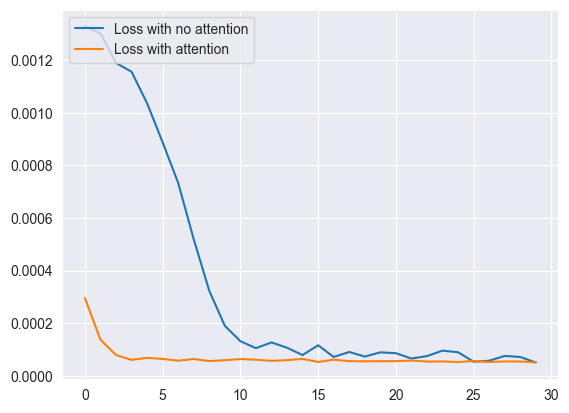

In [21]:
plt.plot(hist_ma.history['loss'])
plt.plot(hist.history['loss'])
plt.legend(['Loss with no attention', 'Loss with attention'], loc='upper left')
plt.show()

---
---
---

In [22]:
from tensorflow.keras.layers import LSTM

def create_LSTM_with_attention(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    
    LSTM_layer = LSTM(
        hidden_units, 
        return_sequences=True, 
        activation=activation
    )(x)
    
    attention_layer = attention()(LSTM_layer)
    
    outputs = Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    
    model=Model(x, outputs)
    
    model.compile(
        loss='mse', 
        optimizer='adam', 
    )
    
    return model

In [23]:
# Create the model with attention, train and evaluate
model_LSTM_attention = create_LSTM_with_attention(
    hidden_units=hidden_units,
    dense_units=1,
    input_shape=(time_steps, 1),
    activation='tanh'
)

model_LSTM_attention.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 10)            480       
                                                                 
 attention_1 (attention)     (None, 10)                30        
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [24]:
hist_LSTM = model_LSTM_attention.fit(
    trainX,
    trainY,
    epochs=epochs,
    batch_size=1,
    verbose=2
)

Epoch 1/30
826/826 - 5s - loss: 0.0014 - 5s/epoch - 6ms/step
Epoch 2/30
826/826 - 4s - loss: 0.0014 - 4s/epoch - 5ms/step
Epoch 3/30
826/826 - 4s - loss: 0.0014 - 4s/epoch - 5ms/step
Epoch 4/30
826/826 - 4s - loss: 0.0014 - 4s/epoch - 5ms/step
Epoch 5/30
826/826 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 6/30
826/826 - 3s - loss: 0.0014 - 3s/epoch - 4ms/step
Epoch 7/30
826/826 - 3s - loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 8/30
826/826 - 3s - loss: 0.0013 - 3s/epoch - 4ms/step
Epoch 9/30
826/826 - 4s - loss: 0.0012 - 4s/epoch - 4ms/step
Epoch 10/30
826/826 - 4s - loss: 0.0012 - 4s/epoch - 5ms/step
Epoch 11/30
826/826 - 4s - loss: 0.0011 - 4s/epoch - 4ms/step
Epoch 12/30
826/826 - 3s - loss: 9.7184e-04 - 3s/epoch - 4ms/step
Epoch 13/30
826/826 - 4s - loss: 7.9870e-04 - 4s/epoch - 4ms/step
Epoch 14/30
826/826 - 3s - loss: 5.6324e-04 - 3s/epoch - 4ms/step
Epoch 15/30
826/826 - 3s - loss: 3.7266e-04 - 3s/epoch - 4ms/step
Epoch 16/30
826/826 - 3s - loss: 1.9328e-04 - 3s/epoch - 4ms/st

In [25]:
hist_LSTM.history.keys()

dict_keys(['loss'])

In [26]:
train_mse_attn_LSTM = model_LSTM_attention.evaluate(trainX, trainY, verbose=2)
test_mse_attn_LSTM = model_LSTM_attention.evaluate(testX, testY, verbose=2)
HR()

print(f"Train with MSE with LSTM attention:\t{train_mse_attn_LSTM:.10f}")
print(f"Test with MSE with LSTM attention:\t{test_mse_attn_LSTM:.10f}")

26/26 - 0s - loss: 8.6268e-05 - 465ms/epoch - 18ms/step
12/12 - 0s - loss: 8.2864e-05 - 40ms/epoch - 3ms/step
----------------------------------------
Train with MSE with LSTM attention:	0.0000862683
Test with MSE with LSTM attention:	0.0000828638


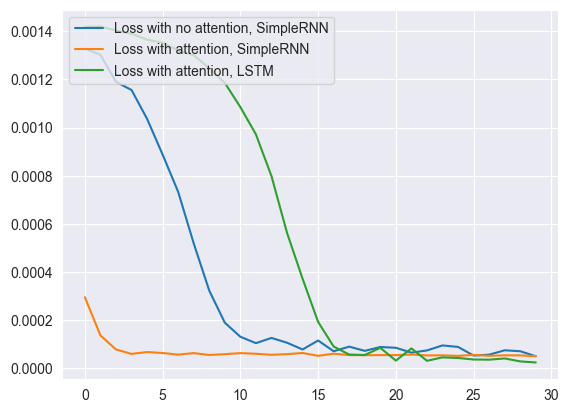

In [27]:
plt.plot(hist_ma.history['loss'])
plt.plot(hist.history['loss'])
plt.plot(hist_LSTM.history['loss'])
plt.legend(['Loss with no attention, SimpleRNN', 'Loss with attention, SimpleRNN', 'Loss with attention, LSTM'], loc='upper left')
plt.show()